# welcome --- Case study 1: Binary Classification ---
# first off, I imported all the necessary libaries required for the task


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Step 1: Load Classification file that was provided in the google drive after which EDA will begin

In [2]:
classification_data = pd.read_csv('classification_data.csv') 

# Step 2: Exploratory Data Analysis (EDA) for Classification Data, Exploratory Data Analysis (EDA) is carried out to understand the dataset better, identify patterns, and detect anomalies or missing values. It helps uncover relationships between variables, assess data distribution, and ensure data quality. By visualizing and summarizing the data, EDA provides insights that guide feature selection, preprocessing decisions, and modeling strategies, ultimately improving the performance and reliability of machine learning models

--- Classification Data EDA ---

Summary Statistics:
              user_id        label  Account type  Duration of Credit (month)  \
count    1000.000000  1000.000000   1000.000000                 1000.000000   
mean   396518.897000     0.700000      2.577000                   20.903000   
std    225382.045777     0.458487      1.257638                   12.058814   
min       505.000000     0.000000      1.000000                    4.000000   
25%    201780.000000     0.000000      1.000000                   12.000000   
50%    395127.500000     1.000000      2.000000                   18.000000   
75%    586323.000000     1.000000      4.000000                   24.000000   
max    797738.000000     1.000000      4.000000                   72.000000   

       Payment Status of Previous Credit      Purpose  Credit Amount  \
count                         1000.00000  1000.000000     1000.00000   
mean                             2.54500     2.828000     3271.24800   
std               

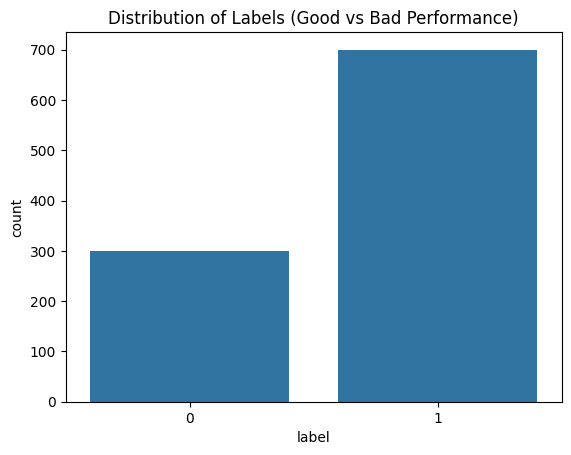

In [3]:
def perform_classification_eda(data):
    print("\nSummary Statistics:\n", data.describe())
    print("\nMissing Values:\n", data.isnull().sum())
    print("\nData Types:\n", data.dtypes)
    
    # Visualizing class distribution, this is done so has to detect if the data is balance or imbalance
    sns.countplot(x='label', data=data)
    plt.title("Distribution of Labels (Good vs Bad Performance)")
    plt.show()

print("--- Classification Data EDA ---")
perform_classification_eda(classification_data)

# Step 3: Preprocessing Classification Data The preprocessing steps are essential to prepare data for effective machine learning. Categorical variables are label-encoded to convert them into numerical formats that models can understand, while missing numerical values are filled with the median to ensure data completeness and avoid errors during training. Feature engineering creates new meaningful features, such as "Credit per Month," to enhance the model's ability to identify patterns. Finally, feature scaling ensures numerical data is standardized, improving model performance and convergence during training. These steps collectively enhance the quality, consistency, and usability of the data for classification tasks.

PLEASE NOTE: FOR THIS TASK, IT IS EVIDENT FROM THE EDA THAT THE CLASSIFICATION DATA HAS NO MISSING VALUE AND IT'S IMBALANCE

In [4]:
def preprocess_classification_data(data):
    # Handle categorical variables using Label Encoding
    categorical_cols = ['Account type', 'Payment Status of Previous Credit', 'Purpose', 'Savings type', 
                        'Most valuable available asset', 'Type of apartment', 'Occupation', 'Telephone', 'Foreign Worker']
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))  # Handle potential missing values
        label_encoders[col] = le

    # Fill missing numerical values with the median
    numerical_cols = [
        'Duration of Credit (month)', 'Credit Amount', 'Length of current employment', 'Instalment per cent', 
        'Duration in Current address', 'Age', 'No of Credits at this Bank'
    ]
    data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

    # Feature Engineering
    data['Credit per Month'] = data['Credit Amount'] / data['Duration of Credit (month)']
    data['Employment per Credit'] = data['Length of current employment'] / data['Credit Amount']

    # Feature scaling for numerical columns
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[numerical_cols + ['Credit per Month', 'Employment per Credit']])
    scaled_data = pd.DataFrame(scaled_features, columns=numerical_cols + ['Credit per Month', 'Employment per Credit'])

    # Combine scaled numerical data with encoded categorical data and target
    processed_data = pd.concat([scaled_data, data[categorical_cols], data['label']], axis=1)
    return processed_data.drop('label', axis=1), data['label']

X, y = preprocess_classification_data(classification_data)

# Step 4: Handle Class Imbalance with SMOTE. I DECIDED TO USE SMOTE BECAUSE FIRST , MY MODEL RESULTS WERE BIAS AS A RESULT OF THE IMBALANCE DATA WHILE USING RANDOM FOREST AS MY ALGORITHMN BUT I AM AWARE THAT XGBOOST IS A GOOD MODEL TO USE WHEN A DATA EXIT IMBALANCE. BUT EVEN AFTER I SWITCHED MY ALGORITHMN I STILL NOTICED BIAS IN MY RESULTS HENCE I DECIDED TO CARRY OUT SMOTE TOGETHER WITH XGBOOST ALG

In [5]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 5: Train-Test Split,The is performed to evaluate the performance of my model on unseen data. It divides the dataset into two parts: the training set for model learning and the test set for validating its predictions. This ensures that the model is not overfitting and can generalize well to new, unseen data, providing a realistic assessment of its performance in real-world scenarios.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Step 6: Hyperparameter Tuning with GridSearchCV, I carried out hyperparameter tuning to systematically tests different values for specified hyperparameters using cross-validation to identify the configuration that maximizes model performance. This ensures the model is fine-tuned for accuracy and avoids underfitting or overfitting, ultimately improving its predictive capabilities.

In [7]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [1, 3.33, 5]  
}
clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

C:\Users\adewa\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:01:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Step 7: Classification Model Training and Evaluation, this involves training the model to classify data into predefined categories and then assessing its performance. During training, the model learns patterns from the training dataset. Evaluation is conducted using metrics like accuracy, precision, recall, F1-score, and AUC-ROC on a test set to measure its ability to generalize to unseen data. This step ensures the model is effective, reliable, and suitable for deployment in real-world classification tasks


--- Classification Report ---

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       208
           1       0.81      0.88      0.85       212

    accuracy                           0.84       420
   macro avg       0.84      0.84      0.84       420
weighted avg       0.84      0.84      0.84       420


Confusion Matrix:
 [[165  43]
 [ 25 187]]

ROC AUC Score:
 0.9225553338171262


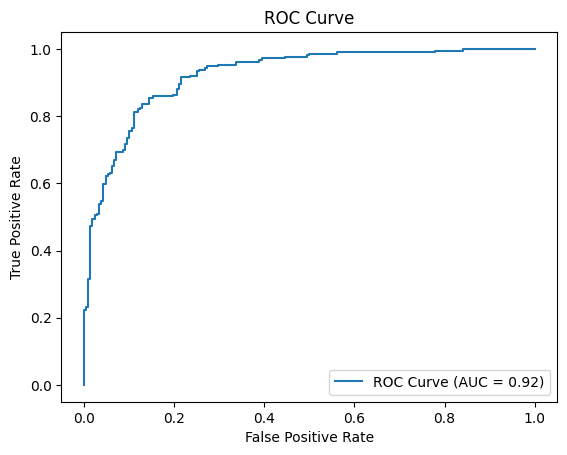

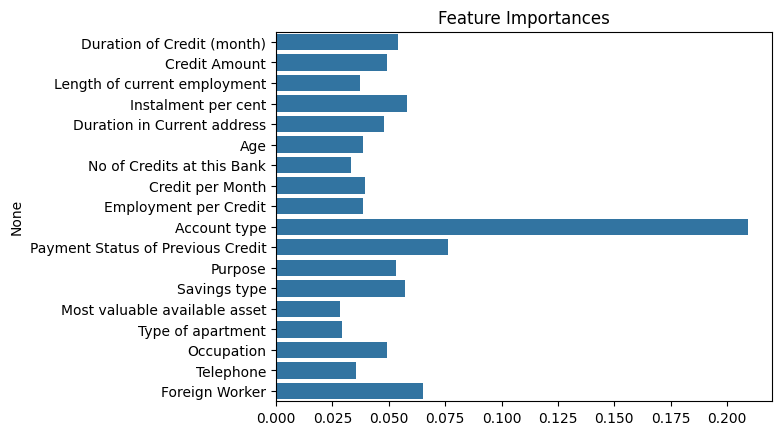

In [8]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report ---\n")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:\n", roc_auc_score(y_test, y_prob))

# Plot ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature Importance Visualization
importances = best_model.feature_importances_
feature_names = X.columns
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances")
plt.show()